### Importing data and checking the high level descriptors i.e. Colunm names.

In [85]:
import pandas

titanic = pandas.read_csv("titanic_train.csv")

print(titanic.head(5))
print(titanic.describe())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

C:\Users\Aditya Gogoi\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


#### The Age column of the dataset contains only 714 rows whereas all the other Columns have 891 rows.
#### Obviously some of the rows do no have the value of Age column. We cannot remove these rows as we need more data to make better algorithm.
#### So we will fill the NULL values with the median value of the Age column.

In [86]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())

#### Several of the columns in our dataset are non numeric,because of which they were not shown by our describe() command before.
#### This is a problem. We cannot feed non-numeric data to a ML algorithm and expect it to make sense out of them.
#### Some of these columns we can include and some we have to ignore.
#### We will ignore Ticket, Cabin and Name columns. Ticket and Name columns do not provide much domain knowledge about the  people travelling on the ship (i.e. their status,etc.). The Cabin column has very few rows to gain any information.

#### But we can convert the Sex column to numeric and make the ML algorithm derive predictions out of it.
#### We will assign following values:- (Male - 0; Female - 1)

In [87]:
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

#### The Embarked column tells the embarkation port name abbreviation for each passenger.
#### We can convert these values to numeric just like Sex.
#### The unique values for this column are :- 'S','C','Q' and 'nan'.

In [88]:
print(titanic["Embarked"].unique())

['S' 'C' 'Q' nan]


#### S is the most common embarkation port for the passengers. We will replace the null value in the Embarked column with S.
#### Then we will assign following values to each port :- 0 to S, 1 to C and 2 to Q.

In [89]:
titanic["Embarked"] = titanic["Embarked"].fillna('S')

titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

#### We will use Linear Regression to predict if the passenger could survive or not based on their information.
#### Cross validation will help us ensure that the algorithm does not 'overfit' our present dataset.
#### We will use scikit-learn to make predictions. We will use a Helper from sklearn to split data into cross-validation folds.
#### We will train algorithm on each fold and then make predictions.
#### At the end, we'll have a list of predictions, with each list item containing predictions for the corresponding fold.

In [90]:
# Import the linear regression class and helper for cross validation from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold

# Columns used for prediction
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initializing the algorithm class
alg = LinearRegression()
# Generating cross validation folds for the dataset.  It return the row indices corresponding to train and test fold.
# Each time we train the model on one fold and test it in another. There are a total of 3 folds so there are 3 combinations 
# of training and testing on 2 folds at a time.
# We set random_state to ensure we get the same splits every time we run this.
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    # The predictors we are using to train the algorithm.
    train_predictors = (titanic[predictors].iloc[train,:])
    # The target we are using to train the algorithm.
    train_target = titanic["Survived"].iloc[train]
    # Training the algorithm using the predictors and target.
    alg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = alg.predict(titanic[predictors].iloc[test,:])
    predictions.append(test_predictions)

#### Now that we have the predictions, let us determine how accurate we are.
#### For this we have to first define an 'error metric'. According to Kaggle, it is the % of correct predictions.
#### This basically involves finding the number of values in 'predictions' that are the exact same as their counterparts in titanic["Survived"], and then dividing by the total number of passengers.
#### But first we combine the 3 sets of predictions in one column.

In [91]:
import numpy as np

# Concatenating the 3 prediction numpy arrays into 1.
predictions = np.concatenate(predictions, axis=0)

# Map predictions to outcomes (any prediction above 0.5 will be 'ceilinged' to a 1 and any value equal to or below 0.5
# will be 'floored' to a 0)
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0

accuracy = 0
for i in range(len(predictions)):
    if predictions[i] == titanic["Survived"][i]:
        accuracy += 1

# The accuracy on our predictions based on the observed and recorded values.        
accuracy = accuracy / len(predictions)
print(accuracy)

0.7833894500561167


#### We can see that our predictions are not very accurate (only 78.33%).
#### We can use Logistic Regression to output our Prediction values to 0 and 1.
#### The mapping is done using the logit function. 
#### Passing any value through the logit function will map it to a value between 0 and 1 by "squeezing" the extreme values. sklearn has a logistic regression class we can use.

In [92]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression

# Initialize the algorithm
alg = LogisticRegression(random_state=1)
# Compute the accuracy score for all the cross validation folds. The outcome is same as before but steps are much simpler.
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
# Take the mean of the scores, as we have one score for each fold.
print(scores.mean())

0.787878787879


#### Performing the same steps we performed on Titanic Training data, on the Test data provided by Kaggle.
#### In some cases (like Age) we have used the median values of the Training dataset.

In [93]:
import pandas

titanic_test = pandas.read_csv("titanic_test.csv")

titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())

titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1


titanic_test["Embarked"] = titanic_test["Embarked"].fillna('S')
titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2

titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic_test["Fare"].median())

#### Now we will make algorithm for our Training data and run it on the Test dataset to make predictions on it.
#### We will the create a .csv file as our prediction output and submit this to Kaggle. It will not be very accurate, though. 
#### Because we are predicting on a different dataset than on which we created our alogorithm on.

In [94]:
# Initializing the algorithm
alg = LogisticRegression(random_state=1)

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Training the algorithm using the training data
alg.fit(titanic[predictors], titanic["Survived"])

# Making predictions using the test set.
predictions = alg.predict(titanic_test[predictors])

# Creating a new dataframe with only the columns Kaggle wants from the dataset.
submission = pandas.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

#### Converting prediction to .csv and submitting it to Kaggle.

In [96]:
submission.to_csv("kaggle.csv", index=False)

#### The above submission had an accuracy of only about 75%. For better accuracy, we need:-
#### 1. Better Machine Learning Algorithms
#### 2. Generate better features
#### 3. Combine better ML algorithms
#### This time, we will use the Random Forest algorithm. 

#### Decision trees create a split based on the decision taken on the data.
#### We can build very deep decision trees that are specific to our dataset. They will be very accurate for that very dataset. But the downside is that the decision tree overfits our dataset and is not generic enough to work on other datasets.

#### This is where the random forest algorithm can help. With random forests, we build hundreds of trees with slightly randomized input data, and slightly randomized split points. Each tree in a random forest gets a random subset of the overall training data. Each split point in each tree is performed on a random subset of the potential columns to split on. 
#### By averaging the predictions of all the trees, we get a stronger overall prediction and minimize overfitting.

#### We will use sklearn's random forest implementation in this case. 

In [103]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)

# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
kf = cross_validation.KFold(titanic.shape[0], n_folds=3, random_state=1)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=kf)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.785634118967


#### To improve accuracy of our Random Forest, we should increase the number of 'trees' in it. This is called 'Parameter Tuning'.
#### Training more trees may take time. But because we are averaving many predictions based on smaller datasets, having more trees will increase accuracy greatly upto a point.
#### Having splits that go all the way down, or overly deep in the tree can result in fitting to quirks in the dataset, which will make it useless to other datasets. We can reduce overfitting by increasing min_samples_split and min_samples_leaf which will actually improve our score, as we're making predictions on unseen data. 
#### A model that is less overfit, and that can generalize better, will actually perform better on unseen data, but worse on seen data. 

In [105]:
# Same steps as before but parameters of the Random Forest algorithm have been tweaked for higher accuracy
alg = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=4, min_samples_leaf=2)

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
kf = cross_validation.KFold(titanic.shape[0], n_folds=3, random_state=1)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=kf)
print(scores.mean())

# Mean of Accuracy Scores shown below.

0.81593714927


#### Generating new features like:-
#### 1.The length of the name -- this could pertain to how rich the person was, and therefore their position in the Titanic.
#### 2.The total number of people in a family (SibSp + Parch).
#### This can improve our predictions about survival chance based on social position or family members aboard who helped.
#### We will use lambda function to implement this.

In [107]:
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

In [108]:
# We can see that the 2 columns have been added to the dataframe.
print(titanic.head(2))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris   0  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...   1  38.0      1      0   

      Ticket     Fare Cabin Embarked  FamilySize  NameLength  
0  A/5 21171   7.2500   NaN        0           1          23  
1   PC 17599  71.2833   C85        1           1          51  


#### Another factor that can determine a passengers status is their title. Most people have ordinary titles like 'Mr.','Ms.',etc. But some titles are used by people of a higher status in the society.
#### We will include the Title as a column in the dataframe. For this we will use a function that extracts title from a name and returns it.
#### The title will then be mapped to a numeric value and stored in the Title column of the dataframe.

In [111]:
import re

# The function definition.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles and print how often each one occurs.
titles = titanic["Name"].apply(get_title)
print(pandas.value_counts(titles))

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

# Verify that we converted everything.
print(pandas.value_counts(titles))

# Add in the title column.
titanic["Title"] = titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Lady          1
Don           1
Mme           1
Capt          1
Ms            1
Countess      1
Sir           1
Jonkheer      1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


#### Now we will group the passengers based on their family size. This determines how many people each passenger had a connection with and so got help during the evacuation.
#### We will create a function that takes a PassengerId, and based on their family size, will put them in a dictionary.

In [114]:
import operator

# A dictionary mapping family name to id
family_id_mapping = {}

# A function to get the id given a row
def get_family_id(row):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

# Get the family ids with the apply method
family_ids = titanic.apply(get_family_id, axis=1)

# There are a lot of family ids, so we'll compress all of the families under 3 members into one code.
family_ids[titanic["FamilySize"] < 3] = -1

# Print the count of each unique id.
print(pandas.value_counts(family_ids))

titanic["FamilyId"] = family_ids

-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


#### Feature Engineering
#### Building new features on the dataset for accurate predictions is very important for data analysis.
#### So knowing which features, when built, will provide the maximum benefit plays a great role in feature engineering.
#### sklearn has a function that will help us with feature selection, SelectKBest. This selects the best features from the data, and allows us to specify how many it selects.

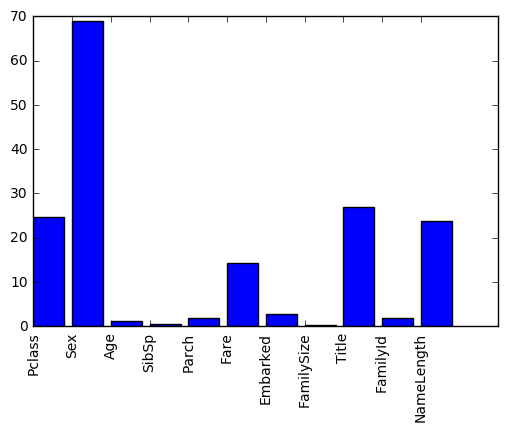

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId", "NameLength"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

#### We can see from the above graph from SelectKBest that some attributes like Pclass, Sex, Fare and Title are some of the columns that provide maximum accuracy for our prediction.
#### So now we will include only these 4 features in our RandomForest algorithm.

In [119]:
# Pick only the four best features.
predictors = ["Pclass", "Sex", "Fare", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=8, min_samples_leaf=4)
kf = cross_validation.KFold(titanic.shape[0], n_folds=3, random_state=1)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=kf)

# Displaying the average accuracy score
print(scores.mean())

0.819304152637


#### Ensembling
#### Ensembling is to gather the predictions from different prediction algorithms, which may or may not use different attributes, and then get their average as the final prediction.
#### Usually ensembling should be done with prediction algorithms that have very different methods Eg:- Random Forest & Linear Regression.
#### But it should only be done if both the algorithms have equally good accuracy. If one of the algorithms has lower accuracy, the final result might be worse.
#### In this case, we'll ensemble logistic regression trained on the most linear predictors (the ones that have a linear ordering, and some correlation to Survived), and a gradient boosted tree trained on all of the predictors.

In [121]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.819304152637


C:\Users\Aditya Gogoi\Anaconda3\lib\site-packages\ipykernel\__main__.py:37: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


#### Now we will match our Training set changes to the Test set data.
#### We will have to add Columns like NameLength, FamilySize, Titl and FamilyId.

In [126]:
# First, we'll add titles to the test set.
titles = titanic_test["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles
# Check the counts of each unique title.
print(pandas.value_counts(titanic_test["Title"]))

# Now, we add the family size column.
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

# Now we can add family ids.
# We'll use the same ids that we did earlier.

family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids

titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
Name: Title, dtype: int64


#### Now we will create the final submission in the same way we did for the previous submission

In [128]:
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4

for i in range(len(predictions)):
    if predictions[i] <= 0.5:
       predictions[i] = 0
    elif predictions[i] > 0.5:
        predictions[i] = 1
        
predictions = predictions.astype(int)

submission = pandas.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

In [136]:
print(titanic_test.head(2))

   PassengerId  Pclass                              Name Sex   Age  SibSp  \
0          892       3                  Kelly, Mr. James   0  34.5      0   
1          893       3  Wilkes, Mrs. James (Ellen Needs)   1  47.0      1   

   Parch  Ticket    Fare Cabin Embarked Title  FamilySize  FamilyId  \
0      0  330911  7.8292   NaN        2     1           0        -1   
1      0  363272  7.0000   NaN        0     3           1        -1   

   NameLength  
0          16  
1          32  


#### We cannot really get to know how much accurate we are this time because that is calculated by Kaggle.  
#### Creating the final CSV file of the prediction.

In [130]:
submission.to_csv("kaggle.csv", index=False)

#### According to Kaggle, the accuracy of this algorithm is 0.79904, which is quite higher than our previous predictions.